In [1]:
# libraries
import pandas as pd
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math, time

# local functions
from utils import import_matrix

## Loading data

In [2]:
root    = './'
city    = 'Dresden'

In [3]:
if city == 'Dresden':
    net_file = os.path.join(root, city, 'net.csv')
    network = pd.read_csv(net_file, sep=',')

    trimmed_cols = [s.strip().lower() for s in network.columns]
    network.columns = trimmed_cols
    

In [4]:
edge_attr = {}
for row in network.itertuples():
    edge_attr[(row[1], row[2])] = {'capacity':row[3], 'length':row[4], 'FFT':row[5], 'alpha':row[6],
                                    'beta':row[7], 'type':row[10], 'flow':0, 'cost':row[5], 'Oflow':None}
    
edge = [(row[1], row[2]) for row in network.itertuples()]

In [5]:
network_graph = nx.DiGraph()
network_graph.add_edges_from(edge)
nx.set_edge_attributes(network_graph, edge_attr)

In [6]:
origin_destination_raw = pd.read_csv(os.path.join(root, city, 'ODdemand.csv'), sep=',', header=0)

origin_destination_demand = {(int(row['Origin']), int(row['Destination'])): int(row['Demand']) for index, row in origin_destination_raw.iterrows()}
# origin_destination_demand

In [7]:
centroid_data = pd.read_csv(os.path.join(root, city, 'centroid.csv'), sep=',')
zones2centroid = centroid_data.groupby('fishnetID')['osmid'].apply(list).to_dict()
# zones2centroid

## All or nothing assignment

In [8]:
def AONloading(graph, zone2centroid, demand, compute_sptt=False):
    """
    All-or-Nothing (AON) traffic assignment with shortest path travel time (SPTT) computation.

    Parameters:
        graph (nx.DiGraph): A directed graph representing the road network, with 'cost' as the edge weight.
        zone2centroid (dict): Maps zones to lists of centroid nodes within each zone.
        demand (dict): OD demand values as a dictionary {(origin_zone, destination_zone): demand}.
        compute_sptt (bool): Flag to compute SPTT and EODTT for OD pairs.

    Returns:
        tuple: 
            - SPTT (float): Total shortest path travel time across all OD pairs.
            - x_bar (dict): Edge flow for each edge in the graph.
            - spedges (dict): Shortest paths for each OD pair (optional, if `compute_sptt` is True).
            - EODTT (dict): End-to-end travel times for OD pairs (optional, if `compute_sptt` is True).
    """
    # Initialize outputs
    x_bar = {edge: 0 for edge in graph.edges()}  # Edge flows
    spedges = {}  # Shortest paths for OD pairs
    EODTT = {}  # End-to-end travel times
    SPTT = 0  # Shortest path travel time
    
    # Iterate through origin zones and their centroid nodes
    for origin_zone, origin_nodes in zone2centroid.items():
        # Compute shortest paths from all centroids in the origin zone
        dijkstra_results = [
            nx.single_source_dijkstra(graph, origin_node, weight="cost") for origin_node in origin_nodes
        ]
        
        # Iterate through destination zones and their centroid nodes
        for destination_zone, destination_nodes in zone2centroid.items():
            if origin_zone == destination_zone:
                continue  # Skip intra-zone flows
            
            # Get the demand for the OD pair
            od_demand = demand.get((origin_zone, destination_zone), 0)
            if od_demand <= 0:
                continue  # Skip if no demand
            
            # Find the shortest path among all centroid-to-centroid paths
            shortest_paths = [
                (dijkstra_results[i][0][dest_node], dijkstra_results[i], dest_node)
                for i in range(len(dijkstra_results))
                for dest_node in destination_nodes
                if dest_node in dijkstra_results[i][0]
            ]
            
            if not shortest_paths:
                continue  # Skip if no valid path exists
            
            # Select the shortest path
            shortest_paths.sort(key=lambda x: x[0])  # Sort by travel time
            min_time, dijkstra_result, destination_node = shortest_paths[0]
            path = dijkstra_result[1][destination_node]
            
            # Compute SPTT and store path/EODTT if required
            if compute_sptt:
                SPTT += min_time * od_demand
                spedges[(origin_zone, destination_zone)] = path
                EODTT[(origin_zone, destination_zone)] = min_time
            
            # Update edge flows
            for u, v in zip(path[:-1], path[1:]):
                x_bar[(u, v)] += od_demand
    
    return SPTT, x_bar, spedges, EODTT


In [9]:
G_AON = network_graph.copy()
SPTT, x_bar, spedges, EODTT = AONloading(G_AON, zones2centroid, origin_destination_demand, compute_sptt=True)
print('SPTT: ', SPTT)
print('x_bar: ', x_bar)
print('spedges: ', spedges)
print('EODTT: ', EODTT)

SPTT:  469992.90680677915
x_bar:  {(442874, 26384674): 1024, (442874, 442928): 0, (26384674, 264670999): 1040, (26384674, 534589): 0, (442928, 1803689295): 0, (442928, 442874): 1024, (442928, 1803689298): 0, (1803689295, 139470345): 0, (264670999, 534589): 970, (264670999, 442936): 146, (264670999, 30403571): 0, (534589, 534591): 970, (1803689298, 1803689295): 0, (1803689298, 442928): 1024, (1803689298, 9946740209): 1, (442936, 15866840): 326, (442936, 264670999): 76, (442936, 2071683): 563, (15866840, 1803689315): 857, (1803689315, 1803689298): 857, (1803689315, 442928): 0, (534591, 534626): 970, (534591, 8083440): 0, (534626, 534624): 205, (534626, 534625): 765, (8083440, 534911): 998, (8083440, 534591): 0, (8083440, 534908): 0, (534911, 534914): 998, (534624, 534608): 771, (534625, 30436908): 765, (534625, 534624): 566, (534608, 30409417): 516, (534608, 30436919): 255, (30409417, 30409422): 288, (30409417, 30403571): 719, (30436919, 30436908): 1569, (30436919, 534608): 0, (30436919,

## Task:
Develop the MSA assignment code that evaulates user equilibrium assignment given the SiouxFalls network and demand



## Work flow to develop MSA
Initial run
* Run dijkstra
* Run AON loading assignment (AON function)
* Update network costs/traveltimes
* Run Dijkstra
* Check relative gap between TSTT and SPTT - Gap is (AON volumes * new costs) / SPTT. SPTT is all demand * min(new costs)

Iterative
* Run AON again
* Calculate MSA volumes/flows
* Update network costs/traveltimes 
* Run dijkstra again
* Check relative gap between TSTT and SPTT - Gap is (MSA volumes * new costs) / SPTT. SPTT is all demand * min(new costs)

In [10]:
def MSA(graph, zone2centroid, demand, max_iterations=100, convergence_threshold=0.05):
    """
    Perform User Equilibrium (UE) Assignment using the Method of Successive Averages (MSA).

    Parameters:
        graph (nx.DiGraph): Directed graph representing the network, with 'cost' as edge weights.
        zone2centroid (dict): Mapping of zones to lists of centroid nodes within each zone.
        demand (dict): OD demand as a dictionary {(origin_zone, destination_zone): demand}.
        max_iterations (int): Maximum number of iterations to run.
        convergence_threshold (float): Threshold for the relative gap to check convergence.

    Returns:
        dict: Final edge flows (volumes) for each edge as {(u, v): flow}.
        list: Convergence history of relative gaps.
    """
    # Initialize edge flows and cost attributes
    for u, v, data in graph.edges(data=True):
        data['flow'] = 0  # Initialize edge flows to zero
        if 'cost' not in data:
            raise ValueError("Graph edges must have an initial 'cost' attribute.")
    
    relative_gaps = []  # To track convergence

    # Step 1: Initial All-or-Nothing (AON) assignment
    print("Running initial AON assignment...")
    SPTT, x_bar, _, _ = AONloading(graph, zone2centroid, demand, compute_sptt=True)

    for iteration in range(1, max_iterations + 1):
        print(f"Iteration {iteration}...")

        # Update flows using MSA: x = x + (1 / iteration) * (x_bar - x)
        for (u, v) in graph.edges():
            graph[u][v]['flow'] = (
                graph[u][v]['flow'] + (1 / iteration) * (x_bar.get((u, v), 0) - graph[u][v]['flow'])
            )

        # Update travel times/costs on the network based on new flows
        update_edge_costs(graph)

        # Step 2: Run shortest path (Dijkstra's algorithm) and AON loading with updated costs
        _, x_bar, _, _ = AONloading(graph, zone2centroid, demand, compute_sptt=False)

        # Step 3: Compute the relative gap
        TSTT = sum(graph[u][v]['flow'] * graph[u][v]['cost'] for u, v in graph.edges())
        SPTT = sum(
            demand.get((origin_zone, destination_zone), 0) * min_cost_between_zones(graph, origin_zone, destination_zone, zone2centroid)
            for origin_zone in zone2centroid
            for destination_zone in zone2centroid
        )
        relative_gap = abs(TSTT - SPTT) / SPTT
        relative_gaps.append(relative_gap)
        
        print(f"Iteration {iteration}: Relative Gap = {relative_gap:.6f} TSTT = {TSTT}")

        # Check for convergence (relative gap < 0.05)
        if relative_gap < convergence_threshold:
            print("Convergence achieved!")
            break

    # Fixed return statement
    return {(u, v): graph[u][v]['flow'] for u, v in graph.edges()}, relative_gaps, graph



def update_edge_costs(graph):
    """
    Update edge travel times (costs) based on current flows using the BPR (Bureau of Public Roads) function.

    Parameters:
        graph (nx.DiGraph): Directed graph representing the network.

    Notes:
        The BPR function is defined as:
            cost = free_flow_time * (1 + alpha * (flow / capacity)^beta)
    """
    alpha = 0.15
    beta = 4
    for u, v, data in graph.edges(data=True):
        free_flow_time = data.get('free_flow_time', 1)
        capacity = data.get('capacity', 1)
        flow = data['flow']
        data['cost'] = free_flow_time * (1 + alpha * (flow / capacity) ** beta)


def min_cost_between_zones(graph, origin_zone, destination_zone, zone2centroid):
    """
    Compute the minimum cost between two zones using shortest paths.

    Parameters:
        graph (nx.DiGraph): Directed graph representing the network.
        origin_zone (int): Origin zone ID.
        destination_zone (int): Destination zone ID.
        zone2centroid (dict): Mapping of zones to centroid nodes.

    Returns:
        float: Minimum cost between the zones.
    """
    origin_nodes = zone2centroid[origin_zone]
    destination_nodes = zone2centroid[destination_zone]
    
    min_cost = float('inf')
    for origin_node in origin_nodes:
        distances, _ = nx.single_source_dijkstra(graph, origin_node, weight='cost')
        for destination_node in destination_nodes:
            if destination_node in distances:
                min_cost = min(min_cost, distances[destination_node])
    
    return min_cost


In [11]:
final_flows, gaps, Assigned_graph = MSA(network_graph, zones2centroid, origin_destination_demand)

print("Final Edge Flows:", final_flows)
print("Relative Gaps:", gaps)

Running initial AON assignment...
Iteration 1...
Iteration 1: Relative Gap = 4.856991 TSTT = 5644810.271681483
Iteration 2...
Iteration 2: Relative Gap = 0.792900 TSTT = 1894091.382647681
Iteration 3...
Iteration 3: Relative Gap = 0.264343 TSTT = 1375675.8830039934
Iteration 4...
Iteration 4: Relative Gap = 0.146289 TSTT = 1251149.3918225572
Iteration 5...
Iteration 5: Relative Gap = 0.103738 TSTT = 1206717.925831105
Iteration 6...
Iteration 6: Relative Gap = 0.088038 TSTT = 1179788.575402384
Iteration 7...
Iteration 7: Relative Gap = 0.067043 TSTT = 1169131.9267197766
Iteration 8...
Iteration 8: Relative Gap = 0.063391 TSTT = 1158328.1335485317
Iteration 9...
Iteration 9: Relative Gap = 0.050778 TSTT = 1154364.0997298686
Iteration 10...
Iteration 10: Relative Gap = 0.046682 TSTT = 1151375.1992542008
Convergence achieved!
Final Edge Flows: {(442874, 26384674): 888.6999999999999, (442874, 442928): 0.0, (26384674, 264670999): 513.5, (26384674, 534589): 469.4, (442928, 1803689295): 0.0, (

In [34]:
# libraries
import geopandas as gpd
import contextily as cx

In [35]:
edges_flows = pd.DataFrame(columns=['from', 'to', 'flow'])

for u,v, data in Assigned_graph.edges(data=True):
    edges_flows = pd.concat([edges_flows, pd.DataFrame.from_records([{'from':u,'to':v, 'flow': Assigned_graph.edges[(u,v)]['flow']}])])

edge_shape = gpd.read_file(os.path.join(root, city, 'shapefiles/edges.geojson')) # for geojson files use edges.geojson

edge_shape = edge_shape.merge(edges_flows, on=['from', 'to'], how='left')
edges_flows = gpd.GeoDataFrame(edge_shape, geometry='geometry')

C:\Users\raman\AppData\Local\Temp\ipykernel_19700\1578780725.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  edges_flows = pd.concat([edges_flows, pd.DataFrame.from_records([{'from':u,'to':v, 'flow': Assigned_graph.edges[(u,v)]['flow']}])])


In [36]:
edges_flows

,from,highway,lanes,length,maxspeed,oneway,osmid,to,capacity,edgeID,geometry,flow
0,442874,primary,3.0,612.679,70,True,"[ 4294198, 103678821, 4294197, 137942318 ]",26384674,900,0,"LINESTRING (13.72277 51.01420, 13.72285 51.014...",888.7
1,442928,primary,2.0,30.892,70,True,30585074,1803689295,900,1,"LINESTRING (13.72258 51.01421, 13.72256 51.014...",0.0
2,26384674,primary_link,1.0,283.786,50,True,"[ 4335235, 2533988 ]",264670999,900,2,"LINESTRING (13.72929 51.01722, 13.72950 51.017...",513.5
3,26384674,primary,2.0,557.894,50,True,"[ 31553764, 1167891187, 1167891188, 1167891190...",534589,900,3,"LINESTRING (13.72929 51.01722, 13.72942 51.017...",469.4
4,1803689298,secondary_link,2.0,43.606,70,True,169207251,1803689295,700,4,"LINESTRING (13.72219 51.01423, 13.72229 51.014...",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1929,3866868160,secondary,1.0,22.127,50,False,383422226,3866868163,700,1929,"LINESTRING (13.71373 51.08059, 13.71386 51.08041)",7.7
1930,3866868160,secondary,2.0,837.459,50,False,"[ 416050402, 383430391, 397727762, 397727763, ...",3866974284,700,1930,"LINESTRING (13.71373 51.08059, 13.71355 51.080...",0.0
1931,3877390786,tertiary,2.0,468.680,50,False,"[ 795991690, 10946190, 384457234, 384457235, 3...",3877452744,600,1931,"LINESTRING (13.82936 51.01055, 13.82928 51.010...",100.2
1932,3952754484,tertiary,1.0,4.332,50,False,218439441,3952754481,600,1932,"LINESTRING (13.72891 51.05202, 13.72889 51.05206)",560.8


(13.5620241, 13.9695939, 50.968211784999994, 51.167934715)

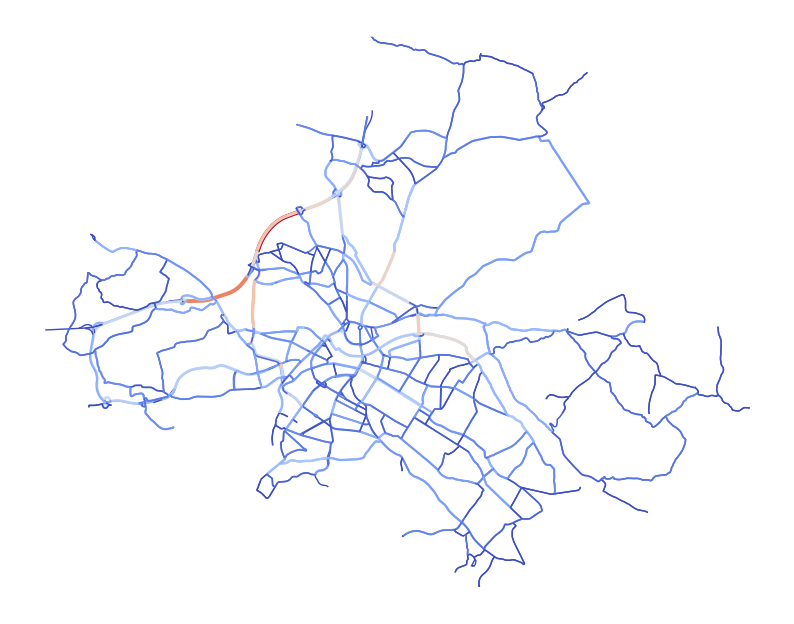

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))

edges_flows.plot(ax=ax, column='flow', cmap='coolwarm', legend=False, linewidth=1+edges_flows['flow'] / 2000)
# cx.add_basemap(ax, crs=edges_flows.crs.to_string(), source=cx.providers.CartoDB.Positron, zoom = 12)


ax.axis('off')


In [19]:
edge_centrality = pd.DataFrame(columns=['from', 'to', 'betweenness', 'Traffic_betweenness'])

centrality = nx.edge_betweenness_centrality(Assigned_graph, weight='TT')

for u,v, data in Assigned_graph.edges(data=True):
    Assigned_graph.edges[(u,v)]['betweenness'] = centrality[(u,v)]

    link_demand_ratio =  Assigned_graph.edges[(u,v)]['flow']*5/origin_destination_raw.Demand.sum()
    Assigned_graph.edges[(u,v)]['Traffic_betweenness'] = centrality[(u,v)]*link_demand_ratio

    edge_centrality = pd.concat([edge_centrality, pd.DataFrame.from_records([{'from':u,'to':v, 'betweenness': centrality[(u,v)],
                                                                                'Traffic_betweenness': centrality[(u,v)]*link_demand_ratio}])])

C:\Users\raman\AppData\Local\Temp\ipykernel_19700\431783175.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  edge_centrality = pd.concat([edge_centrality, pd.DataFrame.from_records([{'from':u,'to':v, 'betweenness': centrality[(u,v)],


In [20]:
edges_shape = gpd.read_file(os.path.join(root, city, 'shapefiles/edges.geojson')) # for geojson files use edges.geojson
edges_shape = edges_shape.merge(edge_centrality, on=['from', 'to'], how='left')
edge_centrality = gpd.GeoDataFrame(edges_shape, geometry='geometry')

(13.5620241, 13.9695939, 50.968211784999994, 51.167934715)

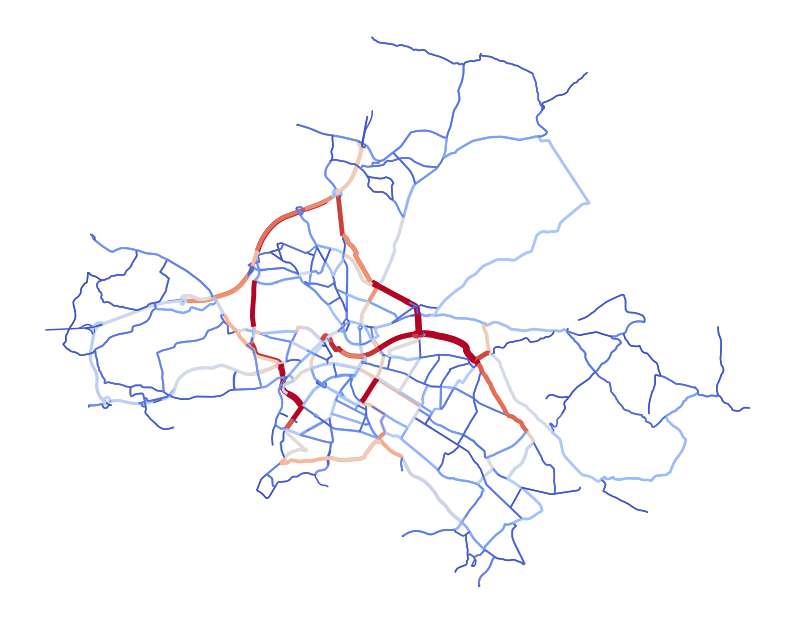

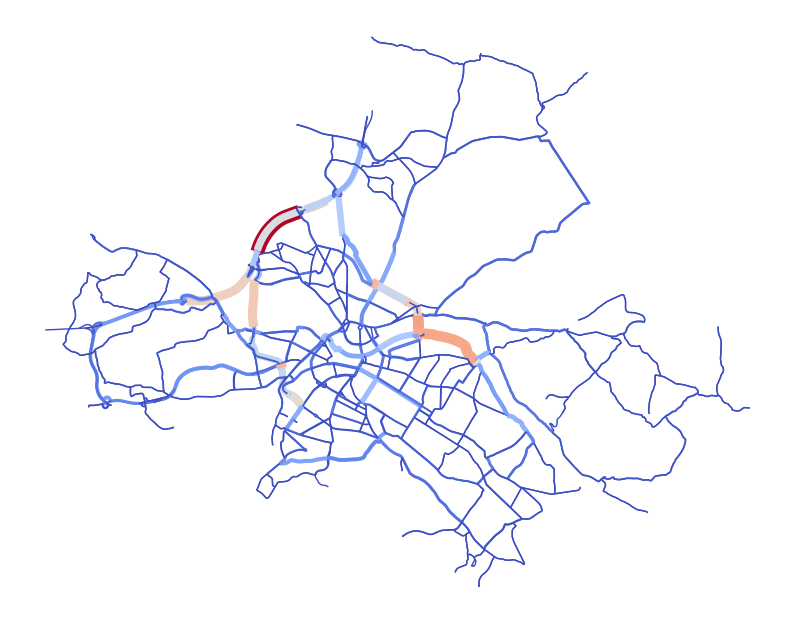

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))

edge_centrality.plot(ax=ax, column='betweenness', cmap='coolwarm', legend=False, vmax = 0.05, linewidth=1+edge_centrality['betweenness'] * 50)
# cx.add_basemap(ax, crs=edge_centrality.crs.to_string(), source=cx.providers.CartoDB.Positron, zoom = 12)
ax.axis('off')

fig, ax = plt.subplots(figsize=(10, 10))

edge_centrality.plot(ax=ax, column='Traffic_betweenness', cmap='coolwarm', legend=False, linewidth=1+edge_centrality['Traffic_betweenness'] * 500)
# cx.add_basemap(ax, crs=edge_centrality.crs.to_string(), source=cx.providers.CartoDB.Positron, zoom = 12)
ax.axis('off')

In [23]:
# OD congestion index
ODCI = {od: EODTT[od] for od in origin_destination_demand if od in EODTT}
# Zone congestion index as origin
ZoneOCI = {zone: [ODCI[od] for od in origin_destination_demand if od in ODCI and od[0] == zone] for zone in list(zones2centroid.keys())}
# average zoneOCI
ZoneOCI = {zone: sum(ZoneOCI[zone])/len(ZoneOCI[zone]) for zone in list(zones2centroid.keys())}
# Zone congestion index as destination
ZoneDCI = {zone: [ODCI[od] for od in origin_destination_demand if od in ODCI and od[1] == zone] for zone in list(zones2centroid.keys())}
# average zoneDCI
ZoneDCI = {zone: sum(ZoneDCI[zone])/len(ZoneDCI[zone]) for zone in list(zones2centroid.keys())}

In [38]:
def calculate_emissions(x):
    b0 = 7.613
    b1 = -0.138565
    b2 = 0.0039151
    b3 = -0.000049519
    b4 = 0.0000002386

    x['cost'] = x['cost']*60  # seconds
    x['Speed'] = x['length']/x['cost']    # m/s
    x['Speed'] = x['Speed']*2.23694       # miles/hr
    if x['Speed'] > 100: x['Speed'] = 100
    
    CO2 = math.exp(b0+b1*x['Speed']+b2*x['Speed']**2+b3*x['Speed']**3+b4*x['Speed']**4)

    x['length'] = x['length']*0.000621371 # miles
    CO2 = CO2*x['length']*x['flow']
    CO2 = CO2/1000   # kg
    #x['Speed'] = x['Speed'].apply(lambda x: x/2.23694)  # m/s
    #x['length'] = x['length'].apply(lambda x: x/0.000621371) #  meters
    return CO2

In [39]:
edge_emissions = pd.DataFrame(columns=['from', 'to', 'emissions'])
for u,v, data in Assigned_graph.edges(data=True):
    Assigned_graph.edges[(u,v)]['emissions'] = calculate_emissions(data.copy())
    #edge_emissions = edge_emissions.append({'from':u, 'to':v, 'emissions':G.edges[(u,v)]['emissions']}, ignore_index=True)
    edge_emissions = pd.concat([edge_emissions, pd.DataFrame.from_records([{'from':u,'to':v, 'emissions': data['emissions']}])])


C:\Users\raman\AppData\Local\Temp\ipykernel_19700\2976025514.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  edge_emissions = pd.concat([edge_emissions, pd.DataFrame.from_records([{'from':u,'to':v, 'emissions': data['emissions']}])])


In [40]:
edges_shape = gpd.read_file(os.path.join(root, city, 'shapefiles/edges.geojson')) # for geojson files use edges.geojson
zones_shape = gpd.read_file(os.path.join(root, city, 'shapefiles/aggrid_polygon.geojson')) # for geojson files use aggrid_polygon.geojson

if 'fishnetID' in zones_shape.columns:
    zones_shape.rename(columns={'fishnetID': 'ZoneID'}, inplace=True)

In [41]:
# add edge_emissions[emissions] column in edges on from and to
edges_shape = edges_shape.merge(edge_emissions, on=['from', 'to'], how='left')
edge_emissions = gpd.GeoDataFrame(edges_shape, geometry='geometry')

In [42]:
# emissions by zone
edge_emissions_byzone = gpd.sjoin(zones_shape, edge_emissions, how='left')[['ZoneID', 'emissions']]
zone_emissions = edge_emissions_byzone.groupby('ZoneID').sum()
zones_shape = zones_shape.merge(zone_emissions, on='ZoneID', how='left')

(13.556524099999999, 13.975093900000001, 50.962711785, 51.173434715)

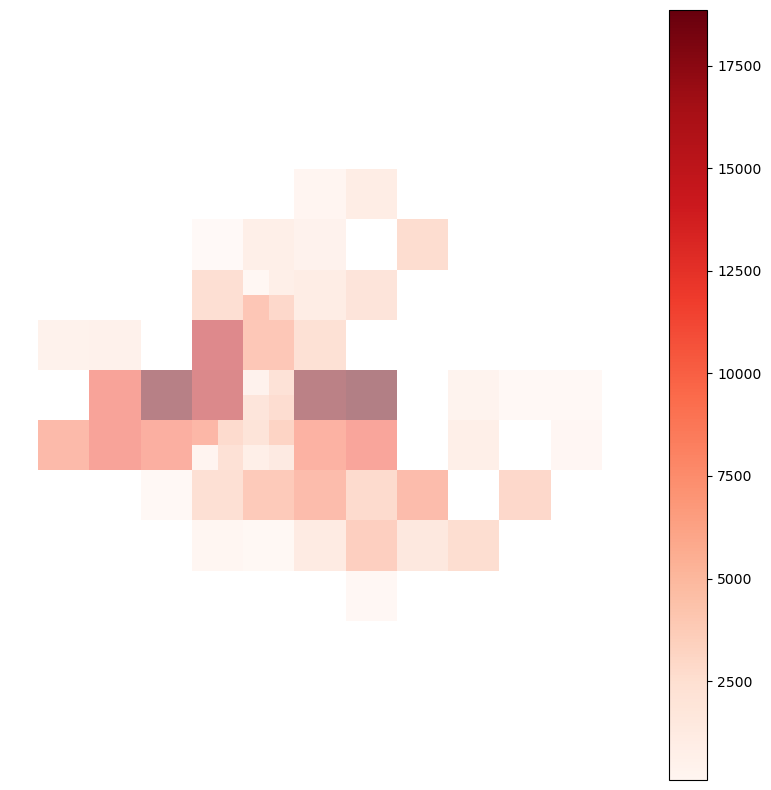

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))

zones_shape.plot(ax=ax, column='emissions', cmap='Reds', legend=True, alpha=0.5)
# cx.add_basemap(ax, crs=zones_shape.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik, zoom = 12)
ax.axis('off')

In [44]:
def calculate_noise(data):
    L0 = 37.3  # Base noise level for light vehicles (can be adjusted) default 50
    k = 30   # Speed correction coefficient we can also use the standard formula
    distance = 25  # Reference distance in meters default 15

    flow = data['flow']  # Flow (vehicles per hour)
    speed = (data['length'] / (data['cost'] * 60)) * 3.6  # Convert m/s to km/h
    speed = min(speed, 100)  # Cap at 100 km/h for realistic values
    Lcar= 27.7 + 10 * np.log10(1 + (0.02 * speed)**3)
    Lhg= 23.1 + 12.5 * np.log10(speed) # speed should be for heavy goods vehicle instead
    f2= 10**(0.1 * (Lhg - Lcar)) 
    k2=2
    speedC= Lcar - L0 + 10 * np.log10((100 + (f2-1)) * k2) / (100 + 8.23 * k2)
    if flow == 0:
        return 0  # No noise if no traffic flow
   
    Noiseavg= L0 + 10 * np.log10(flow * (1 + 0.082 * 3))
    Leq= Noiseavg+speedC
    #Leq = L0 + 10 * np.log10(flow) + k * np.log10(speed) - 20 * np.log10(distance / 15)
    #print(data['length'], data['cost'],speed,flow,Leq)
    return Leq

In [45]:
edge_noise = pd.DataFrame(columns=['from', 'to', 'noise'])
for u, v, data in Assigned_graph.edges(data=True):
    Assigned_graph.edges[(u, v)]['noise'] = calculate_noise(data.copy())
    edge_noise = pd.concat([edge_noise, pd.DataFrame.from_records([{'from': u, 'to': v, 'noise': Assigned_graph.edges[(u, v)]['noise']}])])

C:\Users\raman\AppData\Local\Temp\ipykernel_19700\2052158622.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  edge_noise = pd.concat([edge_noise, pd.DataFrame.from_records([{'from': u, 'to': v, 'noise': Assigned_graph.edges[(u, v)]['noise']}])])


In [46]:
edges_shape = edges_shape.merge(edge_noise, on=['from', 'to'], how='left')
edge_noise = gpd.GeoDataFrame(edges_shape, geometry='geometry')

(13.5620241, 13.9695939, 50.968211784999994, 51.167934715)

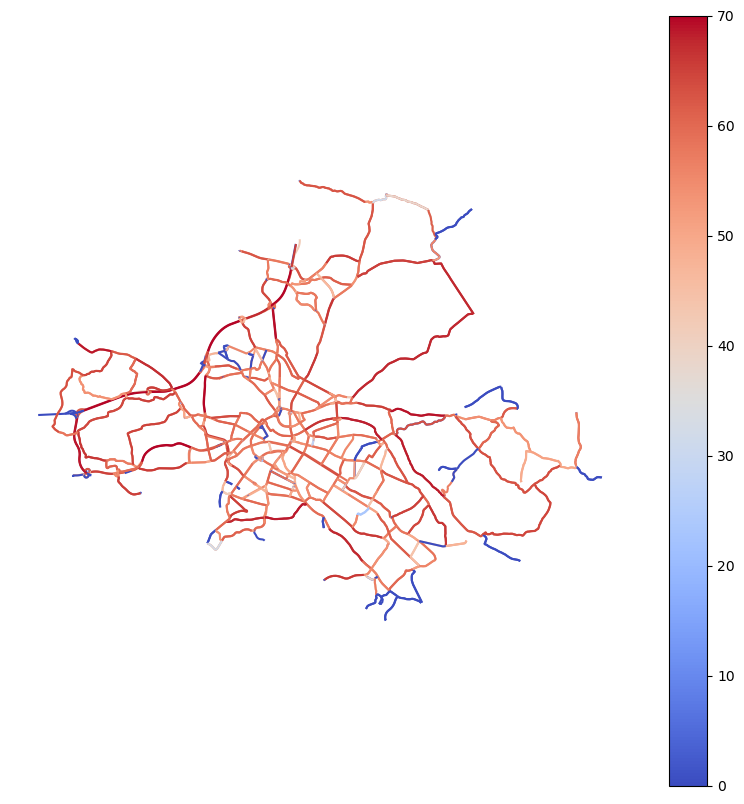

In [47]:
# cell to remove

fig, ax = plt.subplots(figsize=(10, 10))
#edge_noise = edge_noise[edge_noise['noise'] > 60]

edge_noise.plot(ax=ax, column='noise', cmap='coolwarm', legend=True, vmin = 0, vmax = 70)#, linewidth=1+edge_centrality['betweenness'] * 50)
# cx.add_basemap(ax, crs=edge_noise.crs.to_string(), source=cx.providers.CartoDB.Positron, zoom = 12)
ax.axis('off')